In [1]:
import serial
import time
import numpy as np

In [2]:

class Motionstim8:



    def __init__(self):

        # The Motionstim8 device has a serial port
        self.serialPort = serial.Serial()

        # The default main stimulation frequency being used is 20 Hz
        self.stimulationFrequency = 50

        # The default group stimulation frequency being used is 50 Hz
        self.groupStimulationFrequency = 50

        # Set the N factor (0 by default)
        self.nFactor = 0

        # The number of channels in the FES device
        self.nChannels = 8

        # The device channel modes (singlets)
        self.pulseModes = [0] * self.nChannels

        # The device pulse widths
        self.pulseWidths = [300] * self.nChannels

        # The device amplitudes
        self.amplitudes = [0] * self.nChannels




    def OpenSerialPort(self, comPortName):

        # configure the serial connections (the parameters differs on the device you are connecting to)
        self.serialPort.port = comPortName
        self.serialPort.baudrate = 115200
        self.serialPort.parity = serial.PARITY_NONE
        self.serialPort.stopbits = serial.STOPBITS_ONE
        self.serialPort.bytesize = serial.EIGHTBITS
        self.serialPort.timeout = 500
        self.serialPort.write_timeout = 500
        self.serialPort.xonxoff  = False
        self.serialPort.rtscts = False
        self.dsrdtr = False

        # Open the port if not already opened
        if not self.serialPort.is_open:
            self.serialPort.open()




    def CloseSerialPort(self):

        # Close the serial port if it is open
        if self.serialPort.is_open:
            self.serialPort.close()



    def WriteFES(self, bitString):

        # Write a bitstring through the open serial port
        if self.serialPort.is_open:

            # Convert the bit string in to a bytes object
            byteString = int(bitString, 2).to_bytes(len(bitString) // 8, byteorder='big')
            bytesWritten = self.serialPort.write(byteString)
            self.serialPort.flush()

        else:
            print("Error writing to FES device: serial port not opened")



    # A method to initialize the device into Channel List Mode
    def InitializeChannelListMode(self):

        # Set ts1 and ts2
        ts1 = 1000  / self.stimulationFrequency
        ts2 = 1000 / self.groupStimulationFrequency

        # Compute the group and main times
        mainTime = int((ts1 - 1.0) / 0.5)
        groupTime = int((ts2 - 1.5) / 0.5)

        # Set the active channels according to the input
        activeChannelsString = "11111111"

        # Specify which channels apply the scaler to get lower frequencies (none by default)
        lowFrequencyChannelsString = "00000000"

        # Compute checksum
        checksum = (self.nFactor + int(activeChannelsString) + int(lowFrequencyChannelsString) + groupTime + mainTime) % 8

        # Convert each parameter to its correct binary representation
        mainTimeBinary = "{0:011b}".format(mainTime)                              # binary, 11 bit width, 0 padding
        nFactorBinary = "{0:03b}".format(self.nFactor)                                 # binary, 3 bit width, 0 padding
        groupTimeBinary = "{0:05b}".format(groupTime)                             # binary, 5 bit width, 0 padding
        checksumBinary = "{0:03b}".format(checksum)                               # binary, 3 bit width, 0 padding

        # Compose the complete bistring
        bitString = "100"\
                    + checksumBinary\
                    + nFactorBinary[0:2]\
                    + "0"\
                    + nFactorBinary[2:3]\
                    + activeChannelsString[0:6]\
                    + "0"\
                    + activeChannelsString[6:8]\
                    + lowFrequencyChannelsString[0:5]\
                    + "0"\
                    + lowFrequencyChannelsString[5:8]\
                    + "00"\
                    + groupTimeBinary[0:2]\
                    + "0"\
                    + groupTimeBinary[2:5]\
                    + mainTimeBinary[0:4]\
                    + "0"\
                    + mainTimeBinary[4:11]

        # Write the bit string
        self.WriteFES(bitString)



    def UpdateChannelSettings(self, newAmplitudes, newPulses, pulseModes):

        # Ensure that the device amplitudes are capped between the safety bounds 0 - 50 mA
        for index, amplitude in enumerate(newAmplitudes):

            if amplitude > 50:

                self.amplitudes[index] = 50

            elif amplitude < 0:

                self.amplitudes[index] = 0

            else:

                self.amplitudes[index] = newAmplitudes[index]
                
        for i, pulse in enumerate(newPulses):
            self.pulseWidths[i] = pulse
        
        
        for i, mode in enumerate(pulseModes):
            self.pulseModes[i] = mode
#         for i, freq in enumera?te(newFreqs):
#         self.stimulationFrequency = newFreq
        
            
        # Compute checksum
        checksum = (np.sum(self.pulseModes) + np.sum(self.pulseWidths) + np.sum(self.amplitudes)) % 32

        # Construct the channel settings string
        checksumBinary = "{0:05b}".format(checksum)

        channelSettingsBinary = ""
        for amplitude, pulseWidth, pulseMode in zip(self.amplitudes, self.pulseWidths, self.pulseModes):

            pulseWidthBinary = "{0:09b}".format(pulseWidth)
            channelSettingBinary = "0"\
                                   + "{0:02b}".format(pulseMode)\
                                   + "000"\
                                   + pulseWidthBinary[0:2]\
                                   + "0"\
                                   + pulseWidthBinary[2:9]\
                                   + "0"\
                                   + "{0:07b}".format(amplitude)

            channelSettingsBinary += channelSettingBinary

        # Compose the final bitstring
        bitString = "101" + checksumBinary + channelSettingsBinary

        # Write the bit string
        self.WriteFES(bitString)


    def StopDevice(self):

        # Compose the stop command
        stopCommandBinary = "11000000"

        # Write the bit string
        self.WriteFES(stopCommandBinary)

In [3]:
!adb devices

List of devices attached
R52RB0D7XMM	device



In [4]:
import subprocess
import math
import numpy as np
%matplotlib widget
from matplotlib import pyplot as plt
from matplotlib.path import Path

In [5]:

cmd = r'adb shell wm size'

p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)
for line in p1.stdout:
    print(line)
    line = line.decode(encoding="utf-8", errors="ignore")
    line = line.strip()
    if 'Physical size' in line:
        wm_size = (np.array(line.split(' ')[-1].split('\r\n')[0].split('x')).astype(int))
        break
        
wm_center = (wm_size[0]//2, wm_size[1]//2)
wm_size, wm_center

b'Physical size: 1600x2560\r\n'


(array([1600, 2560]), (800, 1280))

Check everything works

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
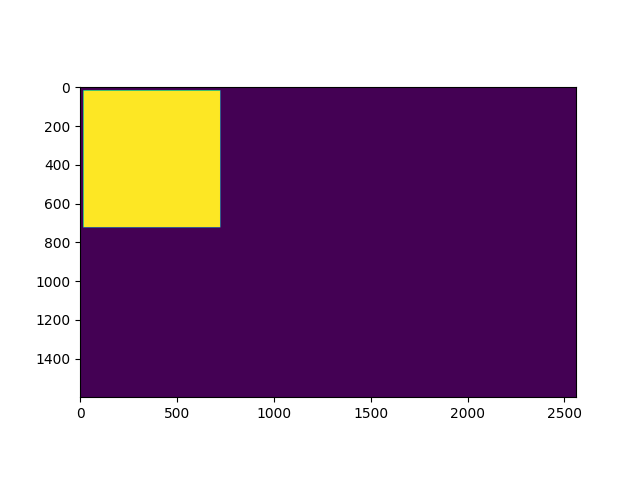

In [6]:
def gen_mask(num_verts, figure_radius, figure_center, first_angle, wm_size):
    

    
    angles = [[np.cos(theta), np.sin(theta)] 
              for theta in np.linspace(first_angle, 
                                       first_angle+2*np.pi, 
                                       num_verts+1)]

    verts = np.array(angles)*figure_radius + figure_center

    polygon=verts
    poly_path=Path(polygon)

    x, y = np.mgrid[:wm_size[0], :wm_size[1]]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

    mask = poly_path.contains_points(coors).reshape(wm_size[0], wm_size[1])
    
    return mask, verts

figure_mask, verts = gen_mask(num_verts=4,
                       figure_radius=500,
                       figure_center=370, 
                       first_angle=np.pi/4,
                       wm_size=wm_size)

plt.figure()
plt.imshow((figure_mask))
plt.show()

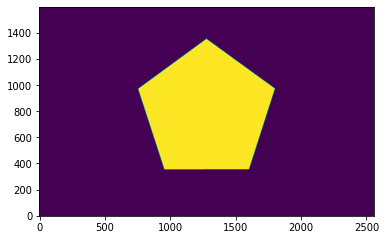

In [14]:
%matplotlib inline

#Choose randomly number of vertex 
num_verts=np.random.choice([4,5,22])
figure_radius=550
figure_center=wm_center 

#Choose randomly number of vertex 
first_angle= np.random.rand() * np.pi
# first_angle = np.pi/4
wm_size=wm_size

figure_mask, figure_verts = gen_mask(num_verts,
                       figure_radius,
                       figure_center,
                       first_angle,
                       wm_size)

plt.figure()
plt.imshow((figure_mask))
plt.gca().invert_yaxis()

In [15]:
#Choose stimulation tyoe here we have inly one
current_stim_group = np.random.choice([0])
# 0 - a 1 - b 
peak_amp      = [ 5][current_stim_group]
baseline_stim = [ 2][current_stim_group]
stim_amp      = peak_amp - baseline_stim
print(['A'][current_stim_group], baseline_stim, stim_amp)

A 2 3


In [16]:
current_stim_group

0

In [17]:

mm=Motionstim8()
mm.OpenSerialPort('/COM3')
mm.InitializeChannelListMode()

Pulses=150
pulseModes=0

In [18]:
#mm.UpdateChannelSettings(newAmplitudes=[4], newPulses=[150], pulseModes=[0])

22-04-02_18-18-30


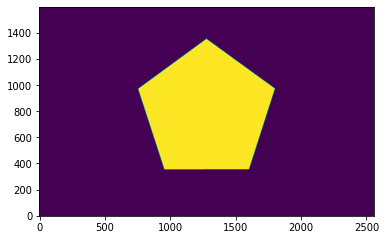

sss


KeyboardInterrupt: 

In [19]:
from datetime import datetime as dt
import os
import subprocess


time_label = dt.now().strftime('%y-%m-%d_%H-%M-%S')
print(time_label)

plt.figure()
plt.imshow((figure_mask))
plt.gca().invert_yaxis()
plt.savefig(os.path.join('session', time_label + '_figure_mask.png'), dpi=300)
plt.show()
session_log_filename = os.path.join('session', time_label + '_session.log')

x, y = 0, 0
cmd = r'adb shell getevent -t /dev/input/event5'

toggle = 0;
toggle_prev = 0;
p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)

print('sss')

with open(session_log_filename, 'w+') as f:
    f.write('Mode = area stim')
    f.write(f'''
    verts = {num_verts} 
    radius = {figure_radius} 
    center = {figure_center} 
    first_angle = {first_angle} 
    wm_size = {wm_size} 
    stim_amp = {stim_amp} 
    baseline_stim = {baseline_stim}
    current_stim_group = {current_stim_group}
    sense_zone = {0}
    ===============================\n''')
    for l in p1.stdout:
        line = l.decode(encoding="utf-8", errors="ignore").strip()
        
        #print(line)

        if ' 0036 ' in line:
            e = line.split(" ")
            x = e[-1]
            x = int(x, 16)
            #print(x) # 0 -- 900, но длинная стороны
            if (y > 0) & (x>0):
                
                #For tpad
                #x_phys = int(np.round(x/800*1920))
                #y_phys = int(np.round(y/1280*1200))
                #print(str((x_phys,y_phys)))
                
                #For Samsung
                x_phys = x
                y_phys = y
                
                #print(str((x_phys,y_phys)))
                toggle = figure_mask[y_phys, x_phys]
                f.write(str(dt.now()) + ' ' + str(toggle) + ' ' + str(line) + '\n')

            

        if  ' 0035 ' in line:
            e = line.split(" ")
            y = e[-1]
            y = int(y, 16)
            #print(y)
            if (y > 0) & (x>0):
                p = (x, y)    
               
                #For tpad
                #x_phys = int(np.round(x/800*1920))
                #y_phys = int(np.round(y/1280*1200))
                #print(str((x_phys,y_phys)))
                
                #For Samsung
                x_phys = x
                y_phys = y
                
                toggle = figure_mask[y_phys, x_phys]
                
                #print(f'{x:04d}, {y:04d} {toggle}', line, end='\r')
                f.write(str(dt.now()) + ' ' + str(toggle) + ' ' + str(line) + '\n')
    
                if toggle!=toggle_prev:
                    # print(str(toggle)+'   '+str(x)+'     '+str(y), end='\r');
                    toggle_prev = toggle
                    #slides[current_stim_group].set_value(toggle*stim_amp+baseline_stim)
                    
                    st=toggle*stim_amp+baseline_stim
                    
                    mm.UpdateChannelSettings(newAmplitudes=[ st], newPulses=[150], pulseModes=[0])
                    
                    while p1.stdout.tell() < -200:
                        p1.stdout.readline()
                

In [20]:
mm.StopDevice()

In [ ]:
p1=subprocess.Popen(cmd,shell=True,stdout=subprocess.PIPE)

In [317]:
mm.StopDevice()

In [ ]:
cmd = r'adb shell getevent -t /dev/input/event2'

In [8]:
for l in p1.stdout:
    line = l.decode(encoding="utf-8", errors="ignore").strip()
    print(line)

[   69997.341163] 0000 0002 00000000
[   69997.341163] 0000 0000 00000000
[   69997.358275] 0001 014a 00000001
[   69997.358275] 0003 0035 0000041c
[   69997.358275] 0003 0036 0000017f
[   69997.358275] 0003 0039 00000001
[   69997.358275] 0000 0002 00000000
[   69997.358275] 0000 0000 00000000
[   69997.375137] 0003 0035 0000041c
[   69997.375137] 0003 0036 0000017f
[   69997.375137] 0003 0039 00000001
[   69997.375137] 0000 0002 00000000
[   69997.375137] 0000 0000 00000000
[   69997.391139] 0003 0035 0000041c
[   69997.391139] 0003 0036 0000017f
[   69997.391139] 0003 0039 00000001
[   69997.391139] 0000 0002 00000000
[   69997.391139] 0000 0000 00000000
[   69997.408051] 0003 0035 00000412
[   69997.408051] 0003 0036 0000017f
[   69997.408051] 0003 0039 00000001
[   69997.408051] 0000 0002 00000000
[   69997.408051] 0000 0000 00000000
[   69997.425360] 0003 0035 00000406
[   69997.425360] 0003 0036 0000017f
[   69997.425360] 0003 0039 00000001
[   69997.425360] 0000 0002 00000000
[

KeyboardInterrupt: 

In [ ]:
p1.stdout: